In [229]:
from typing import Tuple, List, Union
import numpy as np
import matplotlib.pyplot as plt

In [230]:
## Helper functions
def std_deviation(x_arr) -> float:
    """
    Calculates the standard deviation of a given array of numbers.

    Parameters:
    ----------
    x_arr : ndarray
        Array of floats

    Returns:
    -------
    std_dev : float
        The standard deviation of the input array.
    """
    mean = np.mean(x_arr)
    std_dev = 0
    for val in x_arr:
        std_dev += np.power(val - mean, 2)
    return np.sqrt(1.0/(len(x_arr) - 1) * std_dev)

def std_error(x_arr) -> float:
    """
    Calculates the standard error of a given array of numbers.
     Parameters:
    ----------
    x_arr : ndarray
        Array of floats
     Returns:
    -------
    std_error : float
        The standard error of the input array, calculated as the standard deviation
        divided by the square root of the number of elements in the array.
    """
    return std_deviation(x_arr) / np.sqrt(len(x_arr))

In [231]:
def fixed_pricing_revenue(ticket_fraction: int, nr_costumers: int, nr_trials: int) -> Tuple[List[Union[int,float]],List[Union[int,float]], List[Union[int,float]]]:
    if nr_costumers <= 10:
        raise ValueError("Should have n > 10")
    avg_revenues, std_deviations, n_customers = [], [], []
    for _n in range(10,nr_costumers+1):
        nr_tickets = _n//ticket_fraction
        fixed_price = 1-nr_tickets/nr_costumers
        revenues = []
        # Repeating selling to "_n" customers multiple times
        for trial in range(nr_trials):
            ticket_nr = 1
            revenue = 0.0
            # Selling "nr_tickets" to "_n" customers
            for costumer_nr in range(1,_n+1):
                # If any tickets left - try selling
                if ticket_nr <= nr_tickets:
                    v_i = np.random.uniform(low=0.0,high=1)
                    if v_i >= fixed_price:
                        revenue += fixed_price
                        costumer_nr += 1
                # If no tickets left - move to next simulation
                else:
                    break
            revenues.append(revenue)
        n_customers.append(_n)
        avg_revenues.append(np.mean(revenues))
        std_deviations.append(std_deviation(revenues))

    return avg_revenues, std_deviations, n_customers

def variable_pricing_revenue(ticket_fraction: int, nr_costumers: int, nr_trials: int) -> Tuple[List[Union[int,float]], List[Union[int,float]], List[Union[int,float]]]:

    if nr_costumers <= 10:
        raise ValueError("Should have n > 10")

    def p_kn(n,k,exps):
        return (1-exps[n-1,k-1]+exps[n-1,k])/2
    def e_kn(n,k,exps):
        return (1-p_kn(n,k,exps))*(p_kn(n,k,exps)+exps[n-1,k-1])+p_kn(n,k,exps)*exps[n-1,k]

    # Formatted as (n,k): value
    P = np.zeros(shape=(nr_costumers+1,nr_costumers//ticket_fraction+1),dtype=float)
    E = np.zeros(shape=(nr_costumers+1,nr_costumers//ticket_fraction+1),dtype=float)

    for _n in range(0,nr_costumers+1):
        for _k in range(0,nr_costumers//ticket_fraction+1):
            if _k == 0 or _n == 0:
                E[_n,_k] = 0
            else:
                P[_n, _k] = p_kn(_n,_k,E)
                E[_n, _k] = e_kn(_n,_k,E)
    P = np.flip(P[1:,1:])

    avg_revenues, std_deviations, n_customers = [], [], []
    for _n in range(10,nr_costumers+1):
        nr_tickets = _n//ticket_fraction
        revenues = []
        # Repeating selling to "_n" customers multiple times
        for trial in range(nr_trials):
            ticket_nr = 1
            revenue = 0.0
            # Selling "nr_tickets" to "_n" customers
            for costumer_nr in range(1,_n+1):
                # If any tickets left - try selling
                if ticket_nr <= nr_tickets:
                    v_i = np.random.uniform(low=0.0,high=1)
                    if v_i >= P[costumer_nr-1,ticket_nr-1]:
                        revenue += P[costumer_nr-1,ticket_nr-1]
                        costumer_nr += 1
                # If no tickets left - move to next simulation
                else:
                    break
            revenues.append(revenue)
        n_customers.append(_n)
        avg_revenues.append(np.mean(revenues))
        std_deviations.append(std_deviation(revenues))

    return avg_revenues, std_deviations, n_customers



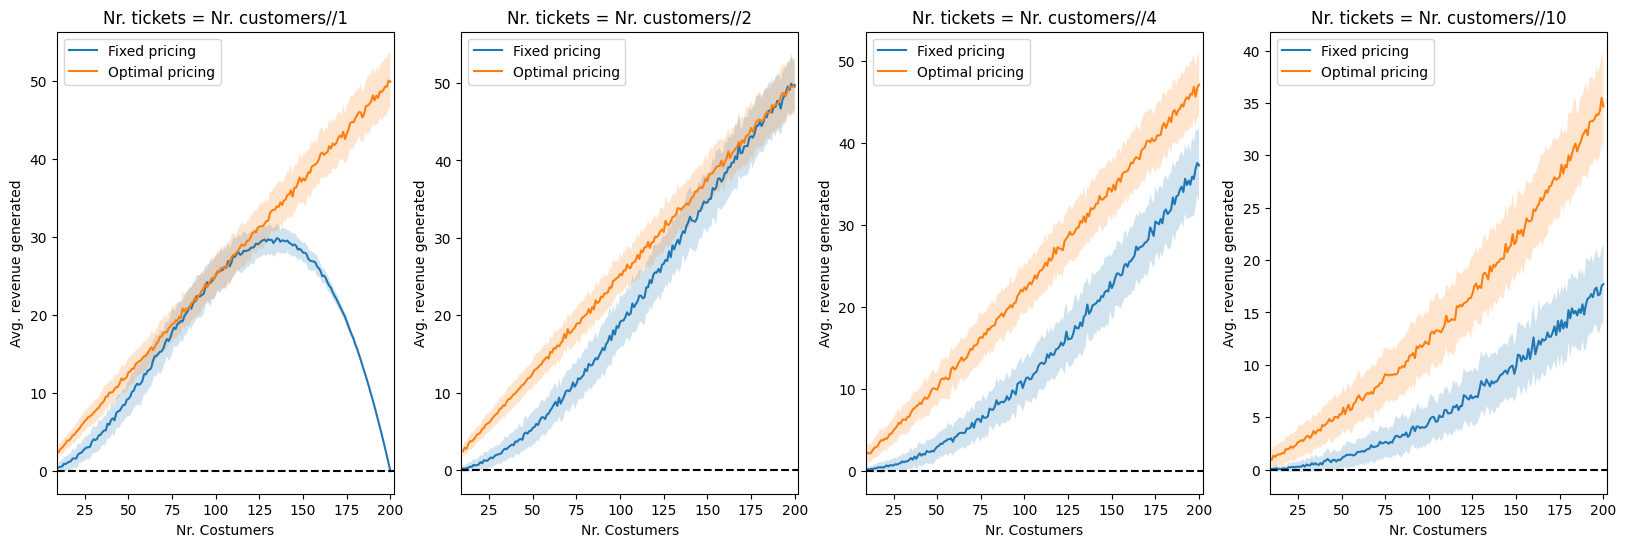

In [235]:
fig, ax = plt.subplots(1,4,figsize=(20,6))

for idx, factor in enumerate([1,2,4,10]):
    div_fav = factor
    N_trials    = 100
    N_costumers = 200
    avg_standard_revenues, standard_std_deviations, n_customers = fixed_pricing_revenue(ticket_fraction=div_fav,nr_costumers=N_costumers,nr_trials=N_trials)
    avg_optimal_revenues, optimal_std_deviations, _ = variable_pricing_revenue(ticket_fraction=div_fav,nr_costumers=N_costumers,nr_trials=N_trials)
    ax[idx].set_title(f"Nr. tickets = Nr. customers//{div_fav}")
    ax[idx].plot(n_customers,avg_standard_revenues, label="Fixed pricing")
    ax[idx].fill_between(n_customers, np.array(avg_standard_revenues)-np.array(standard_std_deviations),
                                 np.array(avg_standard_revenues)+np.array(standard_std_deviations), alpha=0.2)

    ax[idx].plot(n_customers,avg_optimal_revenues, label="Optimal pricing")
    ax[idx].fill_between(n_customers, np.array(avg_optimal_revenues)-np.array(optimal_std_deviations),
                                 np.array(avg_optimal_revenues)+np.array(optimal_std_deviations), alpha=0.2)
    ax[idx].set_xlim(0.9*min(n_customers),1.01*max(n_customers))
    ax[idx].hlines(0,0.9*min(n_customers),1.01*max(n_customers),color='k',ls='--')
    ax[idx].legend(loc='upper left')
    ax[idx].set_xlabel("Nr. Costumers")
    ax[idx].set_ylabel("Avg. revenue generated")
plt.show()